# Text Analysis

Below is some basic initilization, which involves connecting to our remote MongoDB database.

In [73]:
# Custom helper file
import elections_helper as helper
from elections_helper import display_table
from elections_helper import sort_dict
from elections_helper import merge_dicts

import numpy as np
import networkx as nx
import community as cm
import emoji as Emoji
import re, string, operator, pickle, nltk, pprint, math, datetime

import matplotlib.pyplot as plt
%matplotlib inline

from __future__ import division

from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
import plotly.graph_objs as go
init_notebook_mode()

Globally defined variables:

In [2]:
# Twitter users really like these words but we just don't get it.
other_stopwords = ['like','get']

# retrieve common stop words form nltk
stopwords = set(nltk.corpus.stopwords.words('english') + other_stopwords)

# Retrieved dicationary containing word mapped with its happiness index
words_happiness = pickle.load(open('./data_files/sentiment.pickle','rb'))

Connect to remote MongoDB using helper file.

In [3]:
# Connect to MongoDB
client = helper.setup_mongo_client(properties_file='./properties/db.properties')

tweet_collection, user_collection = helper.get_collections(client)

## Understanding our Data

Initially, let's play around with our data a little bit. We're going to practice making simple queries and displaying some of the results.

In [4]:
# Query the database and save result to list
tweets = [tweet for tweet in tweet_collection.find({}, projection={'text': True}).limit(5)]

for num, tweet in enumerate(tweets):
    print "Tweet #%s: %s" % (num, tweet['text'])

Tweet #0: RT @Ethan_Booker: TRUMP: look at this Hillary mask. it's hideous! just like her sou--
AIDE: *whispers in ear*
TRUMP: this mask is beautiful…
Tweet #1: TRUMP: look at this Hillary mask. it's hideous! just like her sou--
AIDE: *whispers in ear*
TRUMP: this mask is bea… https://t.co/IpquTCKM9F
Tweet #2: RT @FoxNews: #DonaldTrump's daughter-in-law, Lara Trump, blasted #HillaryClinton in a new interview. https://t.co/apANzmnyQU #Election2016…
Tweet #3: #DonaldTrump's daughter-in-law, Lara Trump, blasted #HillaryClinton in a new interview. https://t.co/apANzmnyQU… https://t.co/eMohElI9aR
Tweet #4: WikiLeaks: DNC And CNN Colluded On Questions For Trump, Cruz https://t.co/VDETfDgyLi


There's a few things we noticed about the data and it's summarized in the list below:
* Excess text for a retweeted message. ex. RT @MassDeception1:
* Links in tweets
* Mentions in tweets
* Useless puncuation
* Lots of information saved in hashtags!

In order to perform any analysis on our data we need to tokenize it first. Tokenizing is basically converting a string into a list of words. When tokenizing the tweets we can create regular expressions to help handle the potenial issues listed above. Review the tweet_tokenizer function.

Menitons and links in tweets are removed with remove_pattern. The text is the hashtages is matched with hashtag_pattern. The hashtags are all saved and used as tokens. Hashtags with proper camel case are split into seperate words using the hashtag_word_pattern. Finally all puncutation is removed from the tweet.

In [5]:
def tweet_tokenizer(text, extra_stopwords=set([])):
    '''
    
    '''
    # matches mentions, ampersands and twitter links
    remove_pattern = r"(?:@[\w]*|https://t.co/[\w]*|&[\w]*)" 
   
    # matches text found after hashtag
    hashtag_pattern = r"#([^\s]*)"
    
    # pattern to remove puncuation except punctuation x
    punc_pattern = lambda x:  r"[^\w\d" + x + "\s]+"
    
    # match words from hashtag
    hashtag_word_pattern = r'([A-Z][^A-Z]*|[a-z][a-z]*)'
    
    # create a list of all hashtags (not including hash symbol)
    hashtags = re.findall(hashtag_pattern, text)
    
    # remove punctuation from hashtags in case it exists
    hashtags = [re.sub(punc_pattern(''),' ', s) for s in hashtags]
    
    # split hashtag into words
    hashtag_tokens = re.findall(hashtag_word_pattern, ' '.join(hashtags))

    # remove mentions and links from tweet
    text = re.sub(remove_pattern,'', text)
    
    # replaces punctuation with a space, removes hashtags
    text = re.sub(punc_pattern("'#"),' ', text)
    
    # create a combined string of tweet text and words from hashtag
    text = text + ' '.join(hashtag_tokens)
    
    # split text at whitespace
    tokens = text.split()
    
    # try stemming
    # stemmer = SnowballStemmer("english")
    # stemmer.stem(t.lower())
    
    # remove if not in the alphabet and not in stopwords, set to lowercase
    return [t.lower() for t in tokens \
                if t.lower() not in stopwords.union(extra_stopwords) and t.isalpha() and len(t) > 2]

Now testing the tweet_tokenizer function . . .

In [6]:
tweets = [tweet for tweet in tweet_collection.find({'retweeted': False}, projection={'text': True}).limit(5)]

for num, tweet in enumerate(tweets):
    text = tweet['text']
    tokens = tweet_tokenizer(text)  
    print "Tweet #%s: %s" % (num, tokens)

Tweet #0: [u'trump', u'look', u'hillary', u'mask', u'hideous', u'sou', u'aide', u'whispers', u'ear', u'trump', u'mask', u'bea']
Tweet #1: [u'daughter', u'law', u'lara', u'trump', u'blasted', u'new', u'interview', u'donald', u'trump', u'hillary', u'clinton']
Tweet #2: [u'wikileaks', u'dnc', u'cnn', u'colluded', u'questions', u'trump', u'cruz']
Tweet #3: [u'hillary', u'clinton', u'person', u'believed', u'never', u'hillary', u'wikileaks', u'johnpodesta', u'podesta', u'emails']
Tweet #4: [u'bloomberg', u'poll', u'obama', u'would', u'annihilate', u'trump', u'romney', u'would', u'clobber', u'hillary', u'clinton']


## Calculate Frequency Distribution and TF-IDF

To dig a little deeper into what people have been saying about our tweets we will take a look at the frequency distribution of words and the TF-IDF. TF-IDF stands for term frequency - inverse document frequency and it is a measure of important words within a corpus. The corpus for our case is the collection of tweets. From the results of the frequency distribution and TF-IDF we should be able to get a deeper understanding of what people were tweeting about during the election.

The following function tweet_generator is used to return the results of a mongo query.

In [7]:
def tweet_generator(query, get_string=None):
    '''
    Return the a string from a query. Pass a lambda function as get_string outlining how the text will be accessed.
    '''
    
    # if query is a list we need to aggregate
    if type(query) is list:
        cur = tweet_collection.aggregate(query)
    else:
        cur = tweet_collection.find(query)

    for document in cur:
        _id = document['_id']
        if type(_id) is int or type(_id) is long:
            _id = long(_id)
        if get_string:
            result = get_string(document)
            if result:
                yield (result, _id)
        # otherwise yield document
        else:
            yield document, _id    

The function get_bag_words will create a bag of words representation of a set of tweets. A bag of words is a matrix which contains a one if a tweet contains a word and zero otherwise. Each row of the matrix is a tweet and each column is a word.

In [8]:
def get_bag_words(query, get_string=None, extra_stopwords=set([])):

    bag_words = {}
    words = []
    count = 0
    
    for text, _id in tweet_generator(query, get_string):
        
        tokens = tweet_tokenizer(text, extra_stopwords)
        
        bag_words[_id] = tokens
        
        words.extend(tokens)
        
        count += 1
        
    print "Total number of items retrieved is %s" % count

    return bag_words, set(words)

Using the bag of words representation, the term frequency of words in a document can be calculated.

In [9]:
def get_term_frequency(bag_words):
    
    tf = {}
    for _, tokens in bag_words.iteritems():
        for word in tokens:
            # if the key does not exist, set to 1 
            if tf.get(word,None) is None:
                tf[word] = 1
            # add one if the key exists
            else:
                tf[word] += 1
        
    return tf, sort_dict(tf)
    

Using the bag of words representation and term frequency we can calcualte the TF-IDF. Passing in normalize = True will calculate the log normalized term frequency. Setting min_frequency will excempt any words that are below this threshold.

In [10]:
def get_tfidf(bag_words, tf, normalize=True, min_frequency=1):
    
    idf = {}
    tfidf = {}
    
    # first calculate the occurence of words across a corpus
    for _id, tokens in bag_words.iteritems():
        
        # init tfidf matrix
        tfidf[_id] = {}
        
        for word in set(tokens):
            
            tfidf[_id][word] = None
            
            # if the key does not exist, set to 1 
            if idf.get(word,0) == 0:
                idf[word] = 1
            # add one if the key exists
            else:
                idf[word] += 1
                
    N = len(bag_words)
    print "Size of corpus (number of documents) %s" % N
    
    # then calculate the 
    for _id, inner in tfidf.iteritems():
        for word in inner.keys():
            
            frequency = tf[word]
            
            # skip words that are not frequent enough
            if frequency <= min_frequency:
                continue
            
            # compute the term frequency normalization
            if normalize:
                frequency = (1 + math.log(frequency,10))

            tfidf[_id][word] = math.log(1 + N / idf[word],10) * frequency
    
    return tfidf, sort_dict(merge_dicts(*[v for k,v in tfidf.iteritems()]))

Now the the required functions have been built, we can calculate the frequency distribution and TF-iDF.

### All Tweets

First, all the tweets will be used to calculate the frequency distribution and TF-IDF (not including retweets). 

In [85]:
# Retrieve tweets that weren't retweeted
query = {'retweeted': False}

# Retrieve the text field from the tweet
get_string = lambda x: x['text']

# Find a bag of words representation
bag_words, unique_words = get_bag_words(query, get_string)

# Find the frequency distribution
tf, tf_sorted = get_term_frequency(bag_words)
print "Total number of unique words is %s\n" % len(unique_words)

top_ten_frequent_words = tf_sorted[:10]

print "Most frequent words: "
print top_ten_frequent_words

top_ten_frequent_words.reverse()

data = go.Bar(
    x = [i[0] for i in top_ten_frequent_words],
    y = [i[1] for i in top_ten_frequent_words],
)

fig = helper.get_figure(data, 'Top Ten Words from Tweets', 'Word', 'Occurence')
iplot(fig)

# display_table(tf_sorted, title="Most frequent words from Tweets", headers=['Words','Frequency'])

Total number of items retrieved is 71370
Total number of unique words is 34078

Most frequent words: 
[(u'trump', 46373), (u'election', 14873), (u'day', 9544), (u'president', 8609), (u'clinton', 7593), (u'donald', 7477), (u'hillary', 5694), (u'america', 5619), (u'night', 4975), (u'vote', 4925)]


In [90]:
helper.save_plot_as_div(fig, False, './plots/frequent_words_no_query.html')

Many of the frequent words contain the words we used in our queries when getting Twitter data. Let's take a look at what are the most popular words when we ignore these query words.

In [87]:
query_stopwords = [u'financial', u'mexico', u'narrates', u'new', u'final', u'market', u'trump ', \
                   u'riot', u'cabinet', u'hillary', u'president', u'america', u'day', u'thoughts', \
                   u'stock', u'clinton ', u'positions', u'weed', u'planet', u'electionnight', u'clinton', \
                   u'obama', u'elections2016 ', u'elect', u'trump', u'canadian', u'donald', u'election', \
                   u'earth', u'still','night']

In [91]:
# Find a bag of words representation
bag_words, unique_words = get_bag_words(query, get_string, query_stopwords)

# Find the frequency distribution
_, tf_sorted = get_term_frequency(bag_words)

top_ten_frequent_words = tf_sorted[:20]

print "Most frequent words: "
print top_ten_frequent_words

top_ten_frequent_words.reverse()

data = go.Bar(
    x = [i[0] for i in top_ten_frequent_words],
    y = [i[1] for i in top_ten_frequent_words],
)

fig = helper.get_figure(data, 'Top Ten Words from Tweets (not including query words)', 'Word', 'Occurence')
iplot(fig)

Total number of items retrieved is 71370
Most frequent words: 
[(u'vote', 4925), (u'people', 3456), (u'win', 2581), (u'voted', 2540), (u'world', 2092), (u'wins', 2053), (u'one', 1874), (u'going', 1718), (u'white', 1718), (u'would', 1701), (u'right', 1646), (u'make', 1630), (u'think', 1590), (u'good', 1563), (u'know', 1520), (u'via', 1444), (u'today', 1436), (u'voting', 1425), (u'time', 1397), (u'see', 1374)]


Generally when people were tweeting about the election the words vote/voted were used quite frequently.

Next we will calculate the TF-IDF in three ways:

1. Smooth IDF and TF 
> ( 1 + log(size/occurences) ) * tf
2. Smooth IDF and normalized TF
> ( 1 + log(size/occurences) ) * (1 + log(tf))
3. Smooth IDF and normalized TF with a minimum TF of 100
> ( 1 + log(size/occurences) ) * (1 + log(tf)) if tf >= 10

By analyzing the following method we will be able to select the correct method for performing TF-IDF on our tweets.

In [14]:
print 'Smooth IDF and TF'
tfidf, tfidf_sorted = get_tfidf(bag_words, tf, normalize=False)
print tfidf_sorted[:10]

print '\nSmooth IDF and normalized TF'
_, tfidf_sorted = get_tfidf(bag_words, tf)
print tfidf_sorted[:10]

print '\nMinimum word frequency of 100 TF-IDF:'
_, tfidf_sorted = get_tfidf(bag_words, tf, min_frequency=100)
print tfidf_sorted[:10]

Smooth IDF and TF
Size of corpus (number of documents) 71370
[(u'vote', 6104.075305499893), (u'people', 4685.963054884916), (u'win', 3806.7569528162117), (u'voted', 3797.525176872505), (u'world', 3260.189736881924), (u'wins', 3232.526477994719), (u'one', 3014.9385702047366), (u'white', 2838.4426995117924), (u'going', 2821.594692643993), (u'would', 2811.2446362677156)]

Smooth IDF and normalized TF
Size of corpus (number of documents) 71370
[(u'dubai', 9.298709173761077), (u'blah', 9.090160063745648), (u'counting', 9.020739498696368), (u'bye', 8.949604717595758), (u'gang', 8.881102413833117), (u'shirt', 8.869836422815819), (u'biden', 8.861901883759453), (u'neck', 8.846747184391567), (u'choosing', 8.769699129411945), (u'death', 8.750707003324493)]

Minimum word frequency of 100 TF-IDF:
Size of corpus (number of documents) 71370
[(u'dubai', 9.298709173761077), (u'counting', 9.020739498696368), (u'bye', 8.949604717595758), (u'biden', 8.861901883759453), (u'death', 8.750707003324493), (u'we

From the above we can see that not normalizing the term frequency will cause a few issues. When not normalized the highest TF-IDF values generally tend to be the most frequent values. By normalizing we get words that aren't overly frequent accross mutliple tweets.

Some interesting common words we found were 'bye', 'biden', 'death', 'white' and 'leaving'. One downside with using a dataset this vast is that alot of tweets aren't about the election and we get some weird results such as 'dubia'. A newsworthy event may have taken place that captured a sizable population of twitter but not everyone, this caused the TF-IDF value for this entry to be very high.

### Places

Next, tweets that have a location of origin will be used and retweets will not be included. From this analysis we should be able to see what people from different places were talking about.

In [15]:
# The following query will group all the tweets 
query = [{'$match': {'retweeted': False, 'place': {'$ne': None}}},
    {"$group": {"_id": "$place.country",'text': {'$push': '$text'}}},
    {"$project": {"location": "$_id.location",'all_text': '$text'}}
]

# This function will join all the text saved in the all text list only if it has more then 100 tweets
# The list will be generated by Mongo's aggregate function
get_string = lambda x: ' '.join(x['all_text']) if len(x['all_text']) > 1000 else None

# Find a bag of words representation
bag_words, unique_words = get_bag_words(query, get_string, query_stopwords)

# Find the frequency distribution
tf, tf_sorted = get_term_frequency(bag_words)
print "Total number of unique words is %s\n" % len(unique_words)

Total number of items retrieved is 12
Total number of unique words is 25334



In [16]:
tfidf, tfidf_sorted = get_tfidf(bag_words, tf, normalize=True, min_frequency=15)

for place, values in tfidf.iteritems():
    print place
    print sort_dict(values)[:10]
    print

Size of corpus (number of documents) 12
Canada
[(u'dubai', 2.5929178581611345), (u'impacts', 2.198995798670775), (u'vancouver', 1.9958915652655798), (u'cst', 1.9614356285831662), (u'brazil', 1.8677162513475947), (u'toronto', 1.699450340776646), (u'heinous', 1.6507769157817132), (u'sweden', 1.614268076122521), (u'samuel', 1.5763678326709614), (u'popovich', 1.5406137538341171)]

United Kingdom
[(u'zuma', 2.5960414635294673), (u'choosewisely', 2.080967721759438), (u'brazilian', 1.9958915652655798), (u'syllabus', 1.7697669357399435), (u'swedish', 1.623161630509354), (u'presidente', 1.4564449945154023), (u'imstillwithher', 1.4163263090279765), (u'fights', 1.4095318928498548), (u'australia', 1.3902425212688523), (u'department', 1.3544752401323321)]

Australia
[(u'auspol', 3.034688994791726), (u'qand', 2.5632170671285213), (u'turnbull', 2.4552648023662274), (u'qanda', 2.180170061161796), (u'poori', 2.021487376982741), (u'abbott', 1.8626974772987794), (u'heinous', 1.6507769157817132), (u'hai',

From looking at the TF-IDF when group places we can see a lot more variation in words. **DISCLAIMER:** Some of the words when translated contain swear words.

### Queries

Now we will look at grouping tweets that were returned by a specific query.

In [17]:
query = [{'$match': {'retweeted': False}}, 
         {"$group": { "_id": "$root_query", 'text': {'$push': '$text'}}},
         {"$project": {'all_text': '$text'}}]

# similar to before, we will join the list saved in all_text
get_string = lambda x: ' '.join(x['all_text'])

# Find a bag of words representation
bag_words, unique_words = get_bag_words(query, get_string)

# Find the frequency distribution
tf, tf_sorted = get_term_frequency(bag_words)

print "Total number of unique words is %s\n" % len(unique_words)

Total number of items retrieved is 13
Total number of unique words is 33675



In [18]:
tfidf, tfidf_sorted = get_tfidf(bag_words, tf, normalize=True, min_frequency=15)

for query, values in tfidf.iteritems():
    print query
    print sort_dict(values)[:10]
    print

Size of corpus (number of documents) 13
#NewTrumpCabinetPositions
[(u'department', 2.164801273190773), (u'bannon', 2.087645828010348), (u'french', 2.0638396777689993), (u'positions', 2.057262581619161), (u'defence', 2.013542215107921), (u'popovich', 1.9940490050081678), (u'salary', 1.9288821224592476), (u'gregg', 1.928740016689785), (u'article', 1.9185206964602164), (u'blind', 1.9070988971789762)]

stock OR market OR financial OR obama OR weed OR canadian OR mexico
[(u'concern', 2.127592247229762), (u'final', 2.1209754283788196), (u'thoughts', 2.117053452658006), (u'fourth', 2.0666565439729006), (u'difficult', 2.0666565439729006), (u'pak', 2.0320841499224453), (u'japan', 2.013542215107921), (u'kentucky', 1.9805450917472285), (u'however', 1.9805450917472285), (u'brazil', 1.974530975893134)]

#TrumpNarratesPlanetEarth
[(u'narrates', 3.052695597386898), (u'trumpnarratesplanetearth', 2.5563800409399255), (u'hotels', 2.1921597050143062), (u'bannon', 2.087645828010348), (u'sue', 1.9735016076

# Sentiment Analysis

Next we want to determine how exactly people are feeling about the election. We will do so by calculating the sentiment of the tweets. Note, if a tweet does not have the minimum required tokens containing sentiment (min_sentiment_tokes), its average score will be 0.

In [20]:
def get_sentiment(tokens, min_sentiment_tokens=3):
    
    combined_happiness = 0
    words_with_no_sentiment = set()
    words_sentiment_count = 0
    
    # Go through each token and if we have a sentiment for it, add it to the combined happiness score
    for token in tokens:
        # get the happiness value, otherwise return zero
        happiest_value = words_happiness.get(token,0)
        
        # if a happiness value exists keep track 
        if happiest_value != 0:
            combined_happiness += happiest_value
            words_sentiment_count += 1
        # save the words that have no happiness index
        else:
            words_with_no_sentiment.add(token)
    
    # Safe check to avoid division by 0
    if combined_happiness == 0: 
        avg_sentiment_score = 0 
    else: 
        avg_sentiment_score = combined_happiness / words_sentiment_count
    
    # if the tweet does not have a minimum of words that have sentiment, return a score of zero
    if words_sentiment_count <= min_sentiment_tokens:
        return 0, words_with_no_sentiment
    
    return avg_sentiment_score, words_with_no_sentiment

Below we calculate the sentiment for each individual tweet, we also keep track of all the tweets and words that don't have sentiment.

In [21]:
tweet_sentiment = {}
tweets_with_no_sentiment = []
all_words_with_no_sentiment = set()

unique_words = set([])

for tweet, _id in tweet_generator({'retweeted': False}):
    text = tweet['text']
    
    # get tokens
    tokens = tweet_tokenizer(text)
    
    unique_words = unique_words.union(set(tokens))
    
    # calculate sentiment of tweet
    avg_sentiment_score, words_with_no_sentiment = get_sentiment(tokens)
    
    # update set of words with no sentiment
    if len(words_with_no_sentiment) > 0:
        all_words_with_no_sentiment = all_words_with_no_sentiment.union(words_with_no_sentiment)
    
    # If we didn't find any sentiment for the tweet, save the tweet id
    if avg_sentiment_score == 0:
        tweets_with_no_sentiment.append(_id)
    # otherwise save the sentiment to the dictionary
    else:
        tweet_sentiment[_id] = avg_sentiment_score

Now that the sentiment has been calculated we can display some statistics from the sentiment

In [22]:
values = tweet_sentiment.values()

average_sentiment = np.average(values)
std_sentiment = np.std(values)
happiest_value = max(values)
saddest_value = min(values)

tweet_percent = (len(tweet_sentiment) / (len(tweets_with_no_sentiment) + len(tweet_sentiment))) * 100
word_percent = (1 - len(all_words_with_no_sentiment) / len(unique_words)) * 100

happiest_tweet_id = tweet_sentiment.keys()[values.index(happiest_value)]
saddest_tweet_id = tweet_sentiment.keys()[values.index(saddest_value)]

happy_tweet = tweet_collection.find_one({'_id': happiest_tweet_id})['text']
sad_tweet = tweet_collection.find_one({'_id': saddest_tweet_id})['text']

print "The average sentiment of tweet sentiment is   %2.2f" % average_sentiment
print "The stanard deviation of tweet sentiment is   %2.2f" % std_sentiment
print ''
print "Percentage of tweets that have a sentiment    %2.2f%%" % tweet_percent
print "Percentage of words that have a sentiment     %2.2f%%" % word_percent
print ''
print "The happiest tweet is                         %2.2f" % happiest_value
print "Tweet text: %s" % happy_tweet
print ''
print "The saddest tweet is                          %2.2f" % saddest_value
print "Tweet text: %s" % sad_tweet

The average sentiment of tweet sentiment is   5.57
The stanard deviation of tweet sentiment is   0.45

Percentage of tweets that have a sentiment    86.68%
Percentage of words that have a sentiment     23.92%

The happiest tweet is                         7.53
Tweet text: @realDonaldTrump Congratulations For Great victory All Indian with you #electionday

The saddest tweet is                          2.62
Tweet text: Is this the End of Terrorism ( #Elections2016 ) and Corruption? ( #ModiFightsCorruption )


From these results we can see that **tweets about the election were very neutral** with a score of 5.57. Another thing to note is that only 24% of words have sentiment. This is mainly due to the fact that tweets have such a small amount of characters and mainly consist of stopwords. Another downfall of sentiment analysis is that in cannot pick up on the context of the tweet. For example the saddest tweet contains the word terrorism and corruption but the tweet does not appear to be sad and almost optimistic by asking "is this the end of".

In [23]:
headers = ['Tweet ID','Happiness Index']

display_table(sort_dict(tweet_sentiment), title="Happiest Tweets", limit=10, headers=headers)

display_table(sort_dict(tweet_sentiment, reverse=False), title="Unhappiest Tweets", limit=10, headers=headers)

Happiest Tweets (limited to 10 results)
╒════════════════════╤═══════════════════╕
│           Tweet ID │   Happiness Index │
╞════════════════════╪═══════════════════╡
│ 796291278740697088 │           7.53    │
├────────────────────┼───────────────────┤
│ 796291597507796992 │           7.53    │
├────────────────────┼───────────────────┤
│ 795703881317552128 │           7.29    │
├────────────────────┼───────────────────┤
│ 796809782812442624 │           7.26    │
├────────────────────┼───────────────────┤
│ 797587597136633856 │           7.23333 │
├────────────────────┼───────────────────┤
│ 796302267833991168 │           7.21    │
├────────────────────┼───────────────────┤
│ 796329231420706816 │           7.19    │
├────────────────────┼───────────────────┤
│ 796380493684084736 │           7.185   │
├────────────────────┼───────────────────┤
│ 796299322971168768 │           7.17556 │
├────────────────────┼───────────────────┤
│ 796268118528114690 │           7.17    │
╘═════════════

For further analysis we will also consider retweeted tweets, here we create a new dictionary that will contain retweeted tweets as well.

In [25]:
tweet_sentiment_with_retweeted = tweet_sentiment
# set sentiment of retweeted tweets
for tweet, _id in tweet_generator({'retweeted': True}):
    original_id = tweet['retweeted_status']
    sentiment = tweet_sentiment.get(original_id, None)
    if sentiment is None:
        continue
    tweet_sentiment_with_retweeted[_id] = sentiment

## Sentiment of Communities

### Create Community

For this section we are going to incorporate the network we created previously and will calculate the average sentiment of communities found within the graph. First we need to create a new graph that contains only user that we have tweets for. Review the subsection *Creating Network With Users that have Tweets* in the Network section above.

In [37]:
# Load the network from file
directed = pickle.load(open('./data_files/graph2.txt'))

print "The graph has %d nodes" % directed.number_of_nodes() , "and and %d edges "% directed.number_of_edges()

# Remove nodes that have a degree less then 3
to_remove = [node for node,degree in directed.degree().items() if degree < 3]
directed_minimized = directed.copy()
directed_minimized.remove_nodes_from(to_remove)

print "The graph has now %d nodes" % undirected_minimized.number_of_nodes() , "and and %d edges "% undirected_minimized.number_of_edges()

The graph has 5927 nodes and and 12278 edges 
The graph has now 1356 nodes and and 6599 edges 


Now since we have the reduced graph we can calculate the communities of the network and display some information about the users that are inside these communities

In [44]:
# We convert the graph to an undirected network to compute the communities
undirected_minimized = directed_minimized.to_undirected()
partition = cm.best_partition(undirected_minimized)

communities = {}

# Create a dictionary of all communities and their associated user 
for user, community_index in partition.iteritems():
    if community_index in communities:
        communities[community_index].add(user)
    else:
        communities[community_index] = {user}

# Convert dictionary to list
com_list = []

r = 0
for i, c in communities.iteritems():
    # remove all communities with less then 100 users
    if len(c) < 100:
        r += 1
        continue
    print "Length of community %s is %s" % (i-r+1,len(c))
    com_list.append(c)
    
# Top 5 account by in and out degree
for i, c in enumerate(com_list):
    sub = directed_minimized.subgraph(c)
    node_in_degree_tuples = sorted([(node, sub.in_degree(node)) for node in sub.nodes()], key=lambda (n, d): -d)
    node_out_degree_tuples = sorted([(node, sub.out_degree(node)) for node in sub.nodes()], key=lambda (n, d): -d)
    print("In community ", i+1)
    print("The top ten accounts by in degree are : ")
    print( node_in_degree_tuples[:5])
    print("The top ten accounts by out degree are : ")
    print( node_out_degree_tuples[:5])
    print("\n")

Length of community 1 is 159
Length of community 2 is 573
Length of community 3 is 155
Length of community 4 is 429
('In community ', 1)
The top ten accounts by in degree are : 
[(u'Snowden', 8), (u'SenSanders', 7), (u'wikileaks', 7), (u'MarkRuffalo', 6), (u'cenkuygur', 5)]
The top ten accounts by out degree are : 
[(u'SultryRobin', 78), (u'GreenPartyUS', 65), (u'RandallJSharp', 52), (u'wikileaks', 48), (u'SaraCLMT', 34)]


('In community ', 2)
The top ten accounts by in degree are : 
[(u'washingtonpost', 14), (u'KeithOlbermann', 13), (u'nytimes', 13), (u'cnnbrk', 13), (u'NPR', 12)]
The top ten accounts by out degree are : 
[(u'sanchezcan', 310), (u'sallykohn', 228), (u'stuartpstevens', 220), (u'kurteichenwald', 220), (u'StevenTDennis', 207)]


('In community ', 3)
The top ten accounts by in degree are : 
[(u'SheriffClarke', 13), (u'seanhannity', 13), (u'IngrahamAngle', 13), (u'DonaldJTrumpJr', 12), (u'realDonaldTrump', 12)]
The top ten accounts by out degree are : 
[(u'AnnCoulter', 50

Below is a plot of one of the communities containing notable members such as the washingtonpost, nytimes and NPR. The size of the nodes is scaled based on the degree of the node. Larger nodes are nodes with higher degrees

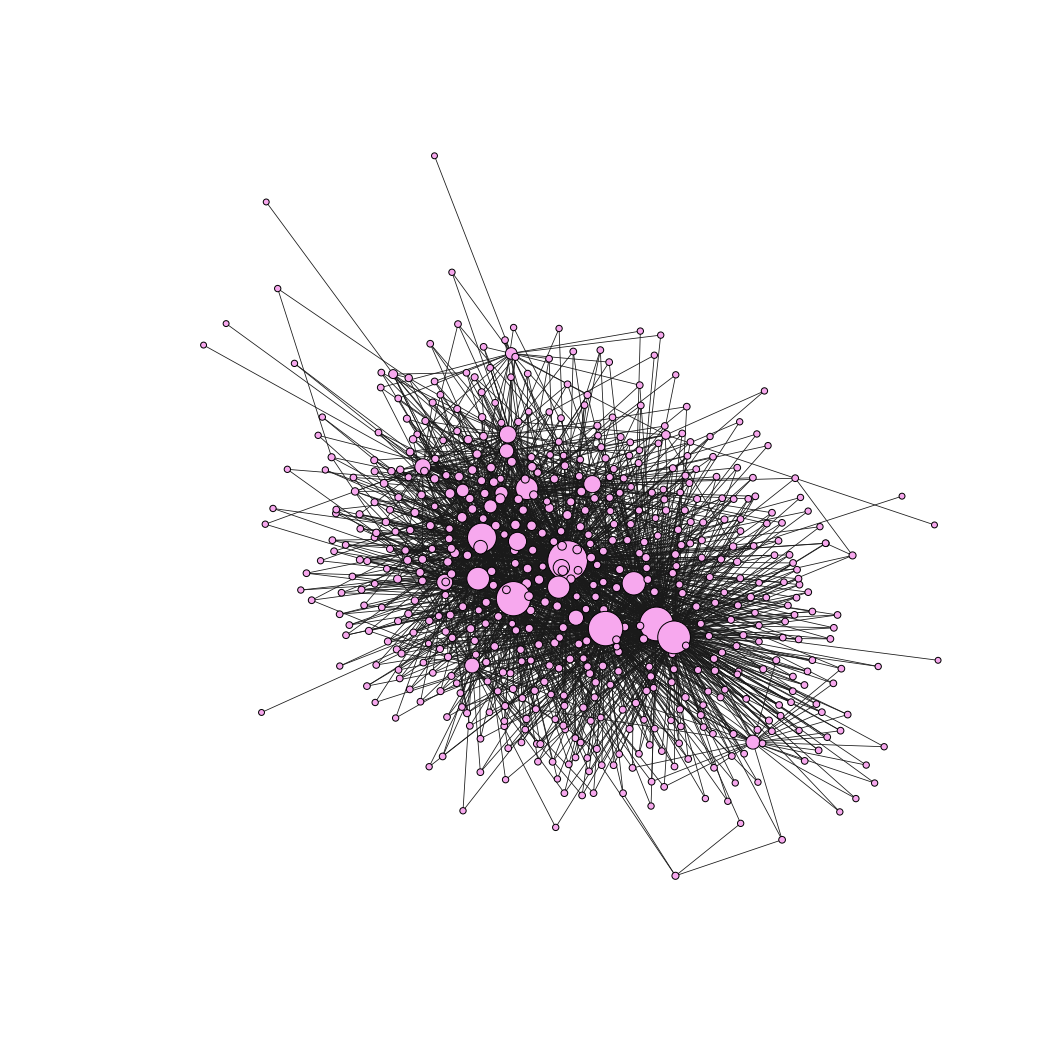

In [50]:
# Plot the second community
sub = directed_minimized.subgraph(com_list[1]).to_undirected()
d = nx.degree(sub)
plt.figure(figsize=(14,14))
nx.draw(sub, node_color="#F7A8EE", node_shape='o', edge_color='.1', with_labels=False, width=0.8, nodelist=d.keys(), node_size=[(v * 5) + 30 for v in d.values()])
plt.show()

List of users in each community is saved to file for easy access later.

In [56]:
for i, c in enumerate(com_list):
    filename = './data_files/community_updated' + str((i+1)) +'.txt'
    with(open(filename, 'w')) as f:
        for screen_name in c:
            f.write(screen_name +'\n')
        f.close()

We will create a dictionary to quickly check if the user is in the user_collection in case there was an error when creating the graph.

In [54]:
# Create a dictionary of user_ids for fast look up
all_screen_names = dict([(user['screen_name'], 1) for user in user_collection.find()])
total_users = len(all_screen_names)
print "Number of users %s" % total_users

Number of users 87501


In [57]:
N = len(com_list) # number of communities
communities_list = []
total_users_in_community = 0
users_with_no_tweets = []

for i in range(1,N+1):
    filename = './data_files/community_updated' + str(i) + '.txt'
    with open(filename) as f:

        community = {}
        # counter to keep track of number of users
        for num_users, user in enumerate(f):
            user = user.replace('\n','')
            # if the user is not in our user collection skip
            if all_screen_names.get(user, 0) == 0:
                users_with_no_tweets.append(user)
                continue

            tweets = tweet_collection.find({'user.screen_name': user})

            community[user] = [long(tweet['_id']) for tweet in tweets]

        size = len(community)
        print "Percentage of users with tweets about the election in community %s is %s%%" \
            % (i, (size/(num_users+1) * 100))

        total_users_in_community += size

        communities_list.append(community)

pickle.dump(communities_list, open('./data_files/communities_with_tweets.pickle', 'wb'))

Percentage of users with tweets about the election in community 1 is 99.3710691824%
Percentage of users with tweets about the election in community 2 is 99.6509598604%
Percentage of users with tweets about the election in community 3 is 98.7096774194%
Percentage of users with tweets about the election in community 4 is 98.3682983683%


In [59]:
for i, c in enumerate(communities_list):
    if len(c) < 100:
        print "Community %s does not have enough users." % (i+1)
        continue
        
    all_community_text = []
    
    for _, tweet_ids in c.iteritems():
        for _id in tweet_ids:
            
            tweet = tweet_collection.find_one({'_id': _id})
            
            all_community_text.append(tweet['text'])
            
    
    community_text = ' '.join(all_community_text)
    
    tokens = tweet_tokenizer(community_text)
    
    avg_sentiment_score,_ = get_sentiment(set(tokens))
    
    print "Average sentiment of community %s is %s" % (i+1, avg_sentiment_score)

Average sentiment of community 1 is 5.39791538933
Average sentiment of community 2 is 5.40855979146
Average sentiment of community 3 is 5.41646389994
Average sentiment of community 4 is 5.41013692769


Here we see that the aggregated sentiment of communities is still around neutral.

## Hedonometer

We can now measure the sentiment of tweets as it changes over time. These plots all called hedonometers. For the hedonometer we need to find the dates for all the tweets, we create a dictionary and save it to a file.

In [ ]:
tweet_dates = {}

# This takes awhile, save and load from file instead
for tweet, _id in tweet_generator({}):
    created_at = helper.convert_datetime(tweet['created_at'])
    tweet_dates[_id] = created_at

pickle.dump(tweet_dates, open('./data_files/tweet_dates.pickle', 'wb'))

In [98]:
def plot_hedonometer(title, start_date, end_date=None, skip_neutral=False, resolution={'second': 0, 'microsecond': 0}):
    '''
    Plot a hedonometer between a start and end date using all tweets with sentiment.
    '''
    
    tweet_dates = pickle.load(open('./data_files/tweet_dates.pickle', 'rb'))
    
    hedonometer = {}
    
    for _id, sentiment in tweet_sentiment_with_retweeted.iteritems():
        
        # Tweets that lie within the standard deviation are not iteresting and removed
        if skip_neutral and sentiment >= (average_sentiment - std_sentiment) and sentiment <= (average_sentiment - std_sentiment):
            continue
            
        date = datetime.datetime.strptime(tweet_dates[_id], '%Y-%m-%d %H:%M:%S').replace(**resolution)

        if end_date is None:
            end_date = datetime.datetime(9999, 12, 31)
        
        # only use tweets between the following dates
        if date >= start_date and date <= end_date:
            if hedonometer.get(date,0) == 0:
                hedonometer[date] = [sentiment]
            else:
                hedonometer[date].append(sentiment)
                
    dates = sorted(hedonometer)

    data = go.Scatter(
        x = dates,
        y = [np.average(hedonometer[date]) for date in dates]
    )

    fig = helper.get_figure(data, title, 'Date', 'Sentiment')
    iplot(fig)
    
    helper.save_plot_as_div(fig, filename="hedonometer2")

In [97]:
october_date = datetime.datetime(2016,10,29)
title = 'Hedonometer from %s (grouped by minute)' % str(october_date.date())
plot_hedonometer(title, october_date)

In [93]:
helper.save_plot_as_div(fig, filename="hedonometer1")

What's particulary strange is how little flucuation there is between November 8th and 10th, the days just following the election. This may be a result of having a higher number tweets during this time period.

In [99]:
election_start_date = datetime.datetime(2016,11,8,5)
election_end_date = datetime.datetime(2016,11,9,0)
title = 'Hedonometer from %s to %s (grouped by minute)' % (election_start_date.date(), election_end_date.date())
plot_hedonometer(title, election_start_date, election_end_date, True, {'second': 0, 'microsecond': 0})

In [95]:
helper.save_plot_as_div(fig, filename="hedonometer2")

## Sentiment analysis through emojis

* Let's take a look at the emojis on Twitter, they might tell us more about the general sentiment of the elections

In [63]:
try:
    # Wide UCS-4 build
    emoji_re = re.compile(u'['
        u'\U0001F300-\U0001F64F'
        u'\U0001F680-\U0001F6FF'
        u'\u2600-\u26FF\u2700-\u27BF]', 
        re.UNICODE)
except re.error:
    # Narrow UCS-2 build
    emoji_re = re.compile(u'('
        u'\ud83c[\udf00-\udfff]|'
        u'\ud83d[\udc00-\ude4f\ude80-\udeff]|'
        u'[\u2600-\u26FF\u2700-\u27BF])', 
        re.UNICODE)

def extract_emoji_tweet(tweet):
    emojis = emoji_re.findall(tweet)
    return emojis

In [64]:
tweets = tweet_collection.find({"retweeted": {"$ne": "true"}}, 
                               {"text": 1, "place": 1, "created_at": 1, "_id": 0})

emoji_counts = {}
emoji_location = {}
emoji_time = {}
for tweet in tweets:
    emojis = extract_emoji_tweet(tweet["text"])
    date = datetime.datetime.strptime(tweet["created_at"][4:13], "%b %d %H").replace(year=2016)
    
    place = tweet["place"]
    if not place:
        place = None
    else:
        place = place["country"]
    
    for emoji in emojis:
        # Simple counts
        if emoji not in emoji_counts:
            emoji_counts[emoji] = 0
        emoji_counts[emoji] = emoji_counts[emoji] + 1
        
        # Time
        if emoji not in emoji_time:
            emoji_time[emoji] = {}
        if date not in emoji_time[emoji]:
            emoji_time[emoji][date] = 0
        emoji_time[emoji][date] = emoji_time[emoji][date] + 1
        
        # Location
        if emoji not in emoji_location:
            emoji_location[emoji] = {}
        if place not in emoji_location[emoji]:
            emoji_location[emoji][place] = 0
        emoji_location[emoji][place] = emoji_location[emoji][place] + 1

In [65]:
data = go.Bar(
        x=[emoji for emoji, count in emoji_counts.iteritems() if count > 100],
        y=[count for emoji, count in emoji_counts.iteritems() if count > 100],
    )

fig = helper.get_figure(data, 'Distribution of the emojis used in the tweets of the elections', 'Emoji', 'Count')
iplot(fig)

We can see that some emojis stand out, such as the face with tears of joy, the skull/death face, and so on. Let's see how each country uses emojis to express their reaction over the elections. 

* Distribution of the emojis per country

In [66]:
datas = [] 
for emoji, location_counts in emoji_location.iteritems():
#     print location
    locations = [location for location, count in location_counts.iteritems() if location and count > 50]
    counts = [count for location, count in location_counts.iteritems() if location and count > 50]
    data = go.Bar(
            x = locations,
            y = counts,
            name = emoji
        )
    datas.append(data)


fig = helper.get_figure(datas, 'Distribution of the emojis used in the tweets of the elections by country', 'Emoji', 'Location')
iplot(fig)

Astonishingly, a majority of the countries only used the face with tears of joy emoji, and the second most used emoji (in France, Brazil, and Mexico) is a bearded devil face. That doesn't help much, let's look at the distribution over time instead

* Distribution of the emojis over the period of the elections

In [67]:
datas = [] 

october_date = datetime.datetime.now().replace(month=10).replace(year=2016).replace(day=1)

for emoji, time_counts in emoji_time.iteritems():
    times = [time for time, count in time_counts.iteritems() if time >= october_date and count > 100]
    counts = [count for time, count in time_counts.iteritems() if time >= october_date and count > 100]
    data = go.Bar(
            x = times,
            y = counts,
            name = emoji
        )
    datas.append(data)


fig = helper.get_figure(datas, 'Distribution of the emojis used in the tweets of the elections', 'Time', 'Count')
iplot(fig)

The highest scoring emoji on the day of the election is not the devil face, but in fact an emoji representing a boy with medium light skin tone. We can also see the heartbreak emoji appearing between the 9th and the 10th.

As we interested in doing a sentiment analysis based on emojis, we are going to build an hedonometer. 
* First, let's find the top 20 emojis and assign them an happiness score

In [74]:
top20_emojis = sorted([(emoji, count) for emoji, count in emoji_counts.iteritems()], key=lambda (k, v): -v)[:20]

for (emoji, count) in top20_emojis:
    print Emoji.emojize(emoji), count, emoji.encode('unicode-escape')

😂 3595 \U0001f602
🏼 1066 \U0001f3fc
💥 901 \U0001f4a5
💔 755 \U0001f494
😭 704 \U0001f62d
🗽 658 \U0001f5fd
👴 642 \U0001f474
💀 581 \U0001f480
🏻 538 \U0001f3fb
🚨 526 \U0001f6a8
❤ 403 \u2764
👏 385 \U0001f44f
🙏 326 \U0001f64f
⚡ 314 \u26a1
🏽 305 \U0001f3fd
👍 282 \U0001f44d
🏾 259 \U0001f3fe
🖕 251 \U0001f595
🎉 228 \U0001f389
✌ 226 \u270c


In [75]:
#http://unicode.org/emoji/charts/full-emoji-list.html
emoji_score = {
    u"\U0001f602": 12,
    u"\U0001f3fc": 14, # boy medium light skin tone
    u"\U0001f4a5": 19,
    u"\U0001f494": 2, 
    u"\U0001f62d": 4,
    u"\U0001f5fd": 17,
    u"\U0001f474": 6, # old man
    u"\U0001f480": 1,
    u"\U0001f3fb": 7, # old man light skin tone
    u"\U0001f6a8": 11,
    u"\u2764": 20,
    u"\U0001f44f": 15, # clapping hands
    u"\U0001f64f": 9, # folded hands
    u"\u26a1": 5, 
    u"\U0001f3fd": 10, # folded hands medium skin tone
    u"\U0001f44d": 16,
    u"\U0001f3fe": 8, # folded hands dark skin tone
    u"\U0001f595": 3,
    u"\U0001f389": 18, # party popper
    u"\u270c": 13,
}

emoji_score_sorted = sorted([(emoji, score) for emoji, score in emoji_score.iteritems()], key=lambda (emoji, score): -score)
for emoji, score in emoji_score_sorted:
    print emoji, score

❤ 20
💥 19
🎉 18
🗽 17
👍 16
👏 15
🏼 14
✌ 13
😂 12
🚨 11
🏽 10
🙏 9
🏾 8
🏻 7
👴 6
⚡ 5
😭 4
🖕 3
💔 2
💀 1


Now that we have established an arbitrary ranking, let's display the average sentiment as an hedonometer

In [76]:
score_emoji = {score: emoji for emoji, score in emoji_score.iteritems()}

datas = [] 

october_date = datetime.datetime.now().replace(month=10).replace(year=2016).replace(day=1)

emoji_time_score = {}
for emoji, time_counts in emoji_time.iteritems():
    if emoji in emoji_score:
        for time, count in time_counts.iteritems():
            if time < october_date:
                continue
            if time not in emoji_time_score:
                emoji_time_score[time] = (0., 0) 
            emoji_time_score[time] = (emoji_time_score[time][0] + count, 
                                      emoji_time_score[time][1] + emoji_score[emoji] * count)

emoji_time_score_flat = sorted([(time, coeff_score) for time, coeff_score in emoji_time_score.iteritems()], 
                               key=lambda (k, _): k)

scores = [score / coeff for (time, (coeff, score)) in emoji_time_score_flat]            
times = [time for (time, (coeff, score)) in emoji_time_score_flat]
data = go.Scatter(x=times, y=scores, name="Emoji score")
data1 = go.Scatter(x=times,y=[10]*len(scores), name="Neutral baseline")
layout = go.Layout(
    title="Hedonometer based on average emoji score throughout the reactions on Twitter during the elections",
    yaxis=dict(
        tickmode="array",
        ticktext=emoji_score.keys(),
        tickvals=emoji_score.values(),
        showticklabels=True,
        range=[0, 21],
        title="Emoji"
        ),
    xaxis=dict(
        title="Date"
    )
)
fig = go.Figure(data=[data, data1], layout=layout)
iplot(fig)

This is particularly interesting, as we see that the face with a tear of joy represents the average sentiment before the previous week of the election day. Did people think all of that was a complete joke ? 

On November 5 at 1pm, we can witness a sudden drop that is represented by the broken heart emoji, probably correlated to the announce of ISIS to attack voters on election day. And we can also note that only 10 hours before that, the average sentiment was at the heart emoji (the maxium), which also means we need to be careful as the data we have is a fisheye view over the elections. 
We can see that the sentiment varies a lot during the period of the elections, between November 6 and November 13. 